This script train a shallow FNN to approximated the discrete-time dynamics model of the lunar lander.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
np.random.seed(1234)
tf.random.set_seed(1234)

In [4]:
# read data

filepath = '../Data/'
DATA_dict = dict()
num_traj = 40
for i in range(num_traj):
    num = i+41;
    if num >= 10:
        str_num = str(num) # no leading zero
    else:
        str_num = '0'+str(num) # add leading zero
    filename = 'trajdata_'+str_num+'.csv'
    with open(filepath+filename, 'r') as f:
        # remove top row, and store the rest in dictionary
        DATA_dict[i] = np.genfromtxt(f, dtype='f4', delimiter=',', skip_header=1)

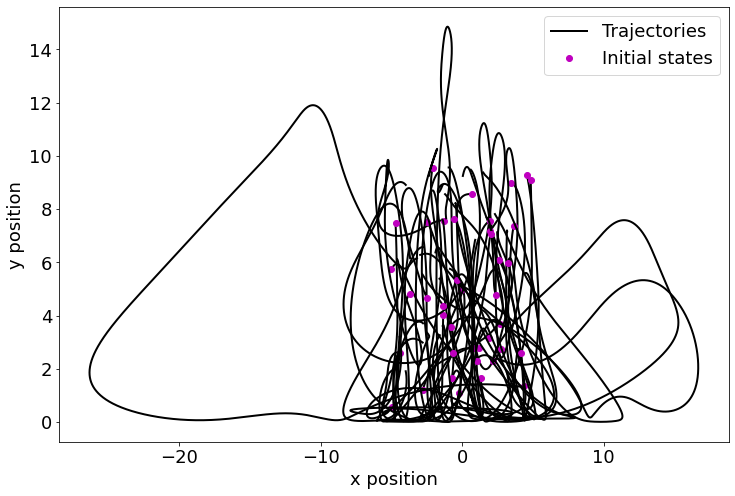

In [5]:
# Plot all position trajectories
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(12,8))

for i in range(num_traj-1):
    curr_traj = DATA_dict[i]
    plt.plot(curr_traj[:,1],curr_traj[:,2],'k-',linewidth=2) # plot trajectory path
    plt.plot(curr_traj[0,1],curr_traj[0,2],'mo') # plot initial position

# Show legend on last trajectory
curr_traj = DATA_dict[num_traj-1]

plt.plot(curr_traj[:,1],curr_traj[:,2],'k-',label='Trajectories', linewidth=2)
plt.plot(curr_traj[0,1],curr_traj[0,2],'mo',label='Initial states')

plt.xlabel('x position')
plt.ylabel('y position')
plt.legend()
#plt.savefig('all-data.png')

In [6]:
# Add 10% Gaussian noise to data

percentage = 0.10

N = 30
for i in range(N):
    stdd = np.std(DATA_dict[i][:,1:], axis=0)
    for j in range(stdd.shape[0]):
        noise = np.random.normal(0, stdd[j], DATA_dict[i][:,j+1].size) * percentage
        DATA_dict[i][:,j+1] = DATA_dict[i][:,j+1] + noise

## Learn from one trajectory

In [7]:
# We select the trajectory as the training set

idx = 23
X = DATA_dict[idx][:-1,1:9]
Y = DATA_dict[idx][1:,1:7]

In [8]:
# define the keras model 8-10-10-6 configuration,
# relu activation for the hidden layer
net = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_dim=8, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(6)])

In [9]:
# compile the keras model
net.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse'])

In [10]:
# fit the keras model on the dataset
net.fit(X, Y, epochs=100, batch_size=10,verbose=2)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
391/391 - 10s - loss: 607.0357 - mse: 607.0357 - 10s/epoch - 26ms/step
Epoch 2/100
391/391 - 3s - loss: 9.9952 - mse: 9.9952 - 3s/epoch - 8ms/step
Epoch 3/100
391/391 - 3s - loss: 5.4399 - mse: 5.4399 - 3s/epoch - 8ms/step
Epoch 4/100
391/391 - 1s - loss: 4.2813 - mse: 4.2813 - 713ms/epoch - 2ms/step
Epoch 5/100
391/391 - 3s - loss: 3.5573 - mse: 3.5573 - 3s/epoch

Epoch 94/100
391/391 - 1s - loss: 0.0782 - mse: 0.0782 - 786ms/epoch - 2ms/step
Epoch 95/100
391/391 - 1s - loss: 0.0779 - mse: 0.0779 - 840ms/epoch - 2ms/step
Epoch 96/100
391/391 - 1s - loss: 0.0793 - mse: 0.0793 - 817ms/epoch - 2ms/step
Epoch 97/100
391/391 - 1s - loss: 0.0837 - mse: 0.0837 - 968ms/epoch - 2ms/step
Epoch 98/100
391/391 - 1s - loss: 0.0812 - mse: 0.0812 - 788ms/epoch - 2ms/step
Epoch 99/100
391/391 - 1s - loss: 0.0785 - mse: 0.0785 - 733ms/epoch - 2ms/step
Epoch 100/100
391/391 - 1s - loss: 0.0761 - mse: 0.0761 - 786ms/epoch - 2ms/step


In [18]:
# We select the last 10 trajectory as the test set
X_test = np.zeros((0,8))
Y_test = np.zeros((0,6))
M = 10
for i in range(M):
    X_test = np.vstack((X_test,DATA_dict[39-i][:-1,1:9]))
    Y_test = np.vstack((Y_test,DATA_dict[39-i][1:,1:7]))

In [19]:
loss_test = net.evaluate(X_test,Y_test,batch_size=X_test.shape[0],verbose=0)
print('The MSE on the test set is',loss_test[0])

The MSE on the test set is 3.9414913654327393


In [20]:
X_test_last = DATA_dict[39][:-1,1:9]
Y_test_last = DATA_dict[39][1:,1:7]
Y_pred_s = net(X_test_last, training=False).numpy()

In [15]:
Y_pred = net(X_test, training=False).numpy()

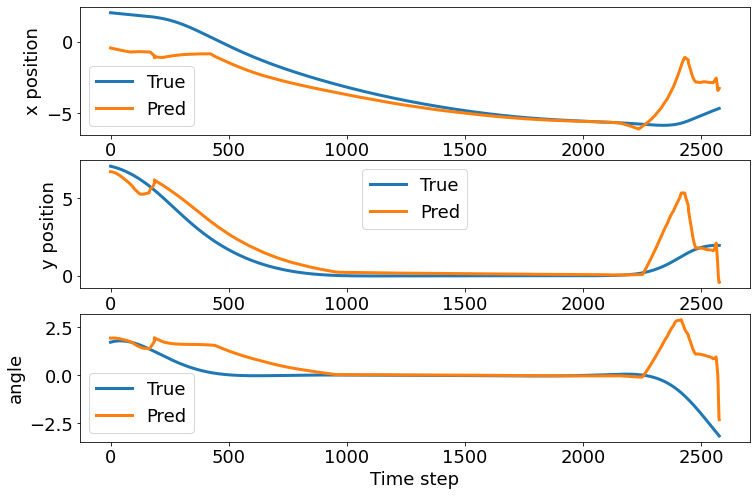

In [35]:
T = range(Y_test_last.shape[0])
fig, axs = plt.subplots(3,figsize=[12,8])
#fig.suptitle('True state v.s. predicted state')
axs[0].plot(T,Y_test_last[:,0], T,Y_pred_s[:,0], linewidth=3)
axs[1].plot(T,Y_test_last[:,1], T,Y_pred_s[:,1], linewidth=3)
axs[2].plot(T,Y_test_last[:,2], T,Y_pred_s[:,2], linewidth=3)
axs[0].set_ylabel('x position')
axs[1].set_ylabel('y position')
axs[2].set_ylabel('angle')
axs[2].set_xlabel('Time step')
axs[0].legend(['True','Pred'])
axs[1].legend(['True','Pred'])
axs[2].legend(['True','Pred'])

In [36]:
fig.savefig('FNN-one-traj-learn.png')

## Learn from multiple trajectories

In [25]:
# We select the first 30 trajectory as the training set
X = np.zeros((0,8))
Y = np.zeros((0,6))
N = 30
for i in range(N):
    X = np.vstack((X,DATA_dict[i][:-1,1:9]))
    Y = np.vstack((Y,DATA_dict[i][1:,1:7]))

In [26]:
# define the keras model 5-10-10-5 configuration,
# relu activation for the hidden layer
net2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_dim=8, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(6)])

In [27]:
# compile the keras model
net2.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse'])

In [28]:
# fit the keras model on the dataset
net2.fit(X, Y, epochs=50, batch_size=100,verbose=2)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
888/888 - 2s - loss: 32.5119 - mse: 32.5119 - 2s/epoch - 3ms/step
Epoch 2/50
888/888 - 2s - loss: 7.0464 - mse: 7.0464 - 2s/epoch - 2ms/step
Epoch 3/50
888/888 - 2s - loss: 3.9843 - mse: 3.9843 - 2s/epoch - 2ms/step
Epoch 4/50
888/888 - 2s - loss: 2.6518 - mse: 2.6518 - 2s/epoch - 2ms/step
Epoch 5/50
888/888 - 2s - loss: 1.9544 - mse: 1.9544 - 2s/epoch - 2ms/step
E

In [29]:
# We select the last 10 trajectory as the test set
X_test = np.zeros((0,8))
Y_test = np.zeros((0,6))
M = 10
for i in range(M):
    X_test = np.vstack((X_test,DATA_dict[39-i][:-1,1:9]))
    Y_test = np.vstack((Y_test,DATA_dict[39-i][1:,1:7]))

In [30]:
loss_test = net2.evaluate(X_test,Y_test,batch_size=X_test.shape[0],verbose=0)
print('The MSE on the test set is',loss_test[0])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
The MSE on the test set is 0.024391604587435722


In [31]:
X_test_last = DATA_dict[39][:-1,1:9]
Y_test_last = DATA_dict[39][1:,1:7]
Y_pred = net2(X_test_last, training=False).numpy()

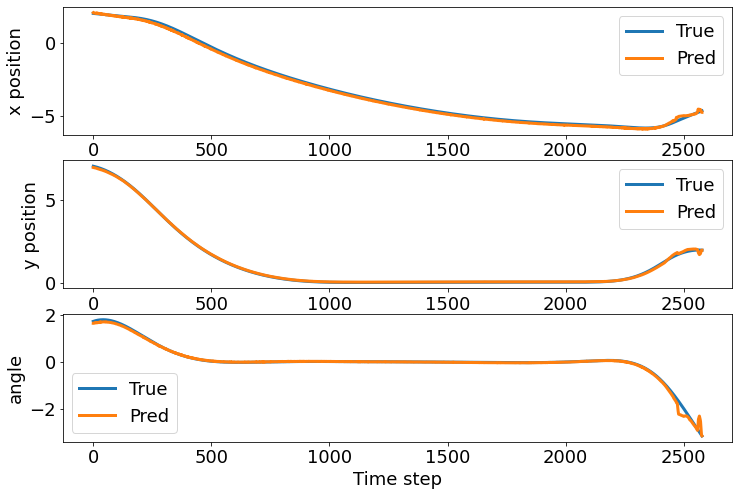

In [33]:
T = range(Y_test_last.shape[0])
fig, axs = plt.subplots(3,figsize=[12,8])
#fig.suptitle('True state v.s. predicted state')
axs[0].plot(T,Y_test_last[:,0], T,Y_pred[:,0], linewidth=3)
axs[1].plot(T,Y_test_last[:,1], T,Y_pred[:,1], linewidth=3)
axs[2].plot(T,Y_test_last[:,2], T,Y_pred[:,2], linewidth=3)
axs[0].set_ylabel('x position')
axs[1].set_ylabel('y position')
axs[2].set_ylabel('angle')
axs[2].set_xlabel('Time step')
axs[0].legend(['True','Pred'])
axs[1].legend(['True','Pred'])
axs[2].legend(['True','Pred'])

In [34]:
fig.savefig('FNN-multi-traj-learn.png')

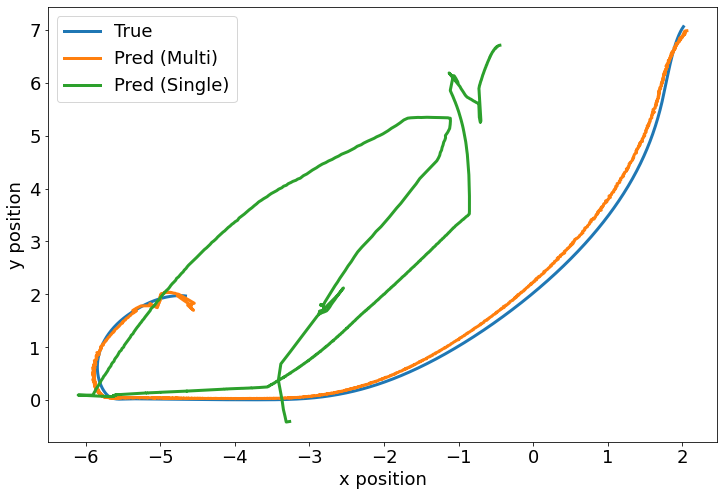

In [38]:
fig, axs = plt.subplots(1,figsize=[12,8])
#fig.suptitle('True state v.s. predicted state')
axs.plot(Y_test_last[:,0],Y_test_last[:,1], Y_pred[:,0], Y_pred[:,1], Y_pred_s[:,0], Y_pred_s[:,1], linewidth=3)
axs.set_xlabel('x position')
axs.set_ylabel('y position')
axs.legend(['True','Pred (Multi)','Pred (Single)'])

In [39]:
fig.savefig('FNN-compare.png')